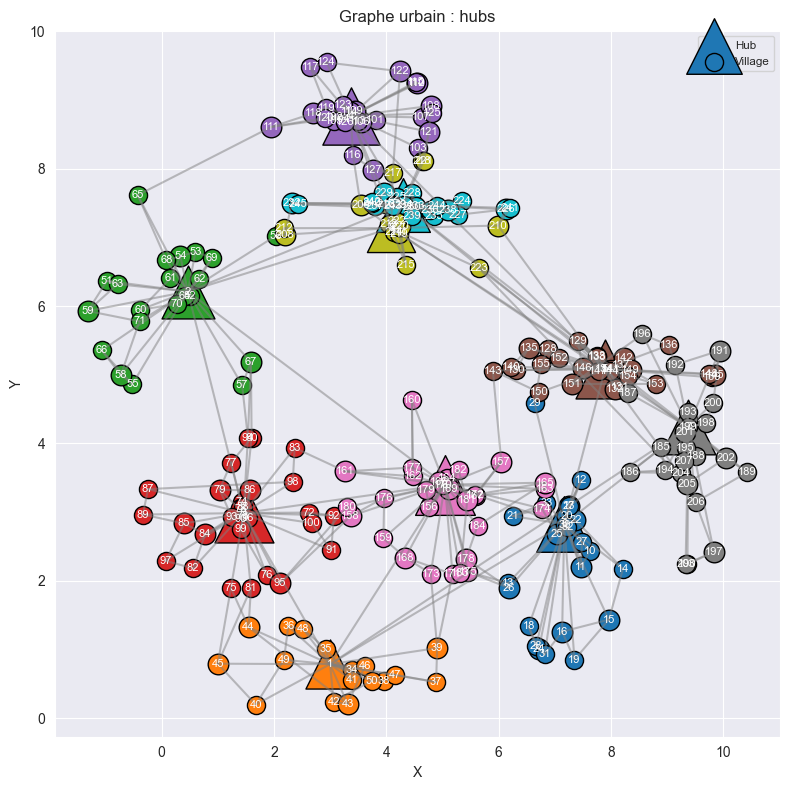

In [16]:
import random
import matplotlib.pyplot as plt
import pprint
import math
import matplotlib.cm as cm
import math
import random
import json
import networkx as nx

def is_connected(enriched):
    G = nx.Graph()
    for node_id, attrs in enriched.items():
        G.add_node(node_id)
        for neighbor_id in attrs['neighbours']:
            G.add_edge(node_id, neighbor_id)
    return nx.is_connected(G), G

def build_logical_graph_data(
    data,
    p_hub=0.6,
    hub_dist_thresh=10,
    k_villages=2,
    max_village_dist=None
):
    """
    Enrichit `data` en lui attribuant des IDs entiers pour hubs et sous‑villes,
    et construit pour chaque nœud :
      - 'cluster'    : ID du hub d'origine
      - 'neighbours' : dict {voisin_id: [poids,...], ...}
    """
    enriched = {}
    vid_map = {}   # map (hub_id, sv_id) → new int ID
    next_vid = 0

    # 1) Assignation des IDs et initialisation des hubs
    for hub_id, hub in data.items():
        vid_map[(hub_id, None)] = next_vid
        enriched[next_vid] = {
            'x': hub['x'], 'y': hub['y'],
            'cluster': next_vid,
            'neighbours': {},
            'distance': 99999
        }
        next_vid += 1

    # 2) Assignation des IDs et initialisation des sous‑villes
    for hub_id, hub in data.items():
        hub_vid = vid_map[(hub_id, None)]
        for sv_id, coord in hub.get('sousVilles', {}).items():
            vid_map[(hub_id, sv_id)] = next_vid
            enriched[next_vid] = {
                'x': coord['x'], 'y': coord['y'],
                'cluster': hub_vid,
                'neighbours': {},
                'distance': 99999
            }
            next_vid += 1

    degres_max_hub = 4
    # 3) Connexions hub–hub
    hubs = [v for (h, sv), v in vid_map.items() if sv is None]
    for i in range(len(hubs)):
        for j in range(i+1, len(hubs)):
            a, b = hubs[i], hubs[j]
            xa, ya = enriched[a]['x'], enriched[a]['y']
            xb, yb = enriched[b]['x'], enriched[b]['y']
            dist = math.hypot(xa-xb, ya-yb)

            da = len(enriched[a]['neighbours'])
            db = len(enriched[b]['neighbours'])
            if dist < hub_dist_thresh and random.random() < p_hub:
                if da < degres_max_hub and db < degres_max_hub:
                    enriched[a]['neighbours'].setdefault(b, []).append(dist)
                    enriched[b]['neighbours'].setdefault(a, []).append(dist)

    degres_max_vil = 3
    # 4) Connexion sous-ville ↔ hub parent
    for hub_id, hub in data.items():
        # on récupère l’ID numérique du hub dans enriched
        hub_vid = vid_map[(hub_id, None)]
        xa, ya = enriched[hub_vid]['x'], enriched[hub_vid]['y']

        # on collecte d’abord les distances hub→sous-villes
        dists = []
        for sv_id, coord in hub.get('sousVilles', {}).items():
            # on récupère l’ID numérique de la sous-ville
            vid = vid_map[(hub_id, sv_id)]
            xb, yb = coord['x'], coord['y']
            d = math.hypot(xa - xb, ya - yb)
            dists.append((d, vid))

        # tri par distance croissante
        dists.sort(key=lambda t: t[0])

        # on connecte TOUTES les sous-villes dont la distance ≤ max_village_dist (si défini)
        for dist, vid in dists:
            if max_village_dist is not None and dist > max_village_dist:
                continue
            enriched[hub_vid]['neighbours'].setdefault(vid, []).append(dist)
            enriched[vid]['neighbours'].setdefault(hub_vid, []).append(dist)

    # 5) Connexion sous‑ville ↔ sous‑ville
    villages = [v for (h, sv), v in vid_map.items() if sv is not None]
    for v in villages:
        xv, yv = enriched[v]['x'], enriched[v]['y']
        # calculer distances aux autres sous‑villes
        dists = []
        for u in villages:
            if u == v: continue
            xu, yu = enriched[u]['x'], enriched[u]['y']
            dist = math.hypot(xv-xu, yv-yu)
            if max_village_dist is not None and dist > max_village_dist:
                continue
            if len(enriched[v]['neighbours']) >= degres_max_vil:
                break
            if len(enriched[u]['neighbours']) >= degres_max_vil:
                continue
            dists.append((dist, u))
        # relier aux k plus proches
        dists.sort(key=lambda t: t[0])
        for dist, u in dists[:k_villages]:
            enriched[v]['neighbours'].setdefault(u, []).append(dist)
            enriched[u]['neighbours'].setdefault(v, []).append(dist)

    # 6) Assurer la connexité
    G = nx.Graph()
    for vid, attrs in enriched.items():
        G.add_node(vid)
        for neigh, w in attrs['neighbours'].items():
            G.add_edge(vid, neigh)
    if not nx.is_connected(G):
        comps = list(nx.connected_components(G))
        for c1, c2 in zip(comps, comps[1:]):
            best = (None, None, float('inf'))
            for a in c1:
                for b in c2:
                    dx = enriched[a]['x'] - enriched[b]['x']
                    dy = enriched[a]['y'] - enriched[b]['y']
                    d = math.hypot(dx, dy)
                    if d < best[2]:
                        best = (a, b, d)
            a, b, d = best
            enriched[a]['neighbours'].setdefault(b, []).append(d)
            enriched[b]['neighbours'].setdefault(a, []).append(d)

    return enriched

def define_cities_regions(data, MIN_X, MAX_X, MIN_Y, MAX_Y, max_iters=10):
    """
    Étend chaque point pour définir sa « boîte » périphérique
    [x1,x2]×[y1,y2], sans empiéter sur ses voisins,
    et limitée à ±(cadre/10) autour du centre.
    """
    # extension max = 1/10 du cadre
    ext_x = (MAX_X - MIN_X) / 10
    ext_y = (MAX_Y - MIN_Y) / 10

    # 1) On démarre : chaque ville peut potentiellement occuper tout l'espace
    for i in data:
        data[i]['periph'] = {
            'x1': MIN_X, 'x2': MAX_X,
            'y1': MIN_Y, 'y2': MAX_Y
        }

    # 2) Ajustements itératifs
    for _ in range(max_iters):
        changed = False

        # --- Phase X ---
        for i, pt in data.items():
            x_i, y1_i, y2_i = pt['x'], pt['periph']['y1'], pt['periph']['y2']
            lefts, rights = [], []

            for j, other in data.items():
                if j == i: continue
                # ignore si bandes Y disjointes
                if other['periph']['y2'] < y1_i or other['periph']['y1'] > y2_i:
                    continue
                midpoint = (x_i + other['x']) / 2
                (lefts if other['x'] < x_i else rights).append(midpoint)

            x1_new = max(lefts) if lefts else MIN_X
            x2_new = min(rights) if rights else MAX_X

            # clamp autour de x_i
            x1_new = max(x1_new, x_i - ext_x)
            x2_new = min(x2_new, x_i + ext_x)

            old = pt['periph']
            if x1_new != old['x1'] or x2_new != old['x2']:
                changed = True
            old['x1'], old['x2'] = x1_new, x2_new

        # --- Phase Y ---
        for i, pt in data.items():
            y_i, x1_i, x2_i = pt['y'], pt['periph']['x1'], pt['periph']['x2']
            lowers, uppers = [], []

            for j, other in data.items():
                if j == i: continue
                # ignore si bandes X disjointes
                if other['periph']['x2'] < x1_i or other['periph']['x1'] > x2_i:
                    continue
                midpoint = (y_i + other['y']) / 2
                (lowers if other['y'] < y_i else uppers).append(midpoint)

            y1_new = max(lowers) if lowers else MIN_Y
            y2_new = min(uppers) if uppers else MAX_Y

            # clamp autour de y_i
            y1_new = max(y1_new, y_i - ext_y)
            y2_new = min(y2_new, y_i + ext_y)

            old = pt['periph']
            if y1_new != old['y1'] or y2_new != old['y2']:
                changed = True
            old['y1'], old['y2'] = y1_new, y2_new

        if not changed:
            break
    
    data = expand_cities_regions(data, MIN_X, MAX_X, MIN_Y, MAX_Y)
    return data

def expand_cities_regions(data, MIN_X, MAX_X, MIN_Y, MAX_Y):
    """
    Pour chaque hub, agrandit sa boîte periph de ±2 unités autour
    du centre, sans empiéter sur les voisins :
      - à GAUCHE : on calcule x1 = max(MAX x2 des bloqueurs, MIN_X, cx - 2)
      - à DROITE: x2 = min(MIN x1 des bloqueurs, MAX_X, cx + 2)
      - en BAS   : y1 = max(MAX y2 des bloqueurs, MIN_Y, cy - 2)
      - en HAUT  : y2 = min(MIN y1 des bloqueurs, MAX_Y, cy + 2)
    """
    ext_x = (MAX_X - MIN_X) / 5.0
    ext_y = (MAX_Y - MIN_Y) / 5.0

    for i, hub in data.items():
        xi, yi = hub['x'], hub['y']

        # --- gauche ---
        cand = MIN_X
        # plafond d’extension
        left_ext = xi - ext_x
        cand = max(cand, left_ext)
        # mi-distance au plus proche voisin à gauche
        mids = []
        for j, other in data.items():
            if j==i: continue
            y1, y2 = hub['periph']['y1'], hub['periph']['y2']
            oy1, oy2 = other['periph']['y1'], other['periph']['y2']
            # vrai chevauchement Y ?
            if min(y2,oy2) > max(y1,oy1) and other['x'] < xi:
                mids.append((xi + other['x'])/2)
        if mids:
            cand = max(cand, max(mids))
        hub['periph']['x1'] = cand

        # --- droite ---
        cand = MAX_X
        right_ext = xi + ext_x
        cand = min(cand, right_ext)
        mids = []
        for j, other in data.items():
            if j==i: continue
            y1, y2 = hub['periph']['y1'], hub['periph']['y2']
            oy1, oy2 = other['periph']['y1'], other['periph']['y2']
            if min(y2,oy2) > max(y1,oy1) and other['x'] > xi:
                mids.append((xi + other['x'])/2)
        if mids:
            cand = min(cand, min(mids))
        hub['periph']['x2'] = cand

        # --- bas ---
        cand = MIN_Y
        bot_ext = yi - ext_y
        cand = max(cand, bot_ext)
        mids = []
        for j, other in data.items():
            if j==i: continue
            x1, x2 = hub['periph']['x1'], hub['periph']['x2']
            ox1, ox2 = other['periph']['x1'], other['periph']['x2']
            if min(x2,ox2) > max(x1,ox1) and other['y'] < yi:
                mids.append((yi + other['y'])/2)
        if mids:
            cand = max(cand, max(mids))
        hub['periph']['y1'] = cand

        # --- haut ---
        cand = MAX_Y
        top_ext = yi + ext_y
        cand = min(cand, top_ext)
        mids = []
        for j, other in data.items():
            if j==i: continue
            x1, x2 = hub['periph']['x1'], hub['periph']['x2']
            ox1, ox2 = other['periph']['x1'], other['periph']['x2']
            if min(x2,ox2) > max(x1,ox1) and other['y'] > yi:
                mids.append((yi + other['y'])/2)
        if mids:
            cand = min(cand, min(mids))
        hub['periph']['y2'] = cand

    return data

def display(data, MIN_X, MAX_X, MIN_Y, MAX_Y):
    """
    Affiche :
      - Les hubs principaux (cercles noirs) et leurs ID
      - Les sous‑villes de chaque hub (carrés orange) et leur ID hub.sousID
      - La boîte périphérique de chaque hub (segments bleus/rouges)
    data : dict {
        hub_id: {
            'x': float, 'y': float,
            'periph': {'x1','x2','y1','y2'},
            'sousVilles': {
                sous_id: {'x','y'}, …
            }
        }, …
    }
    """
    plt.figure(figsize=(8, 6))

    # 1) Hubs et leurs étiquettes
    for hub_id, attrs in data.items():
        x, y = attrs['x'], attrs['y']
        plt.scatter(x, y, marker='o', color='black',
                    label='Hub' if hub_id == 0 else "")
        plt.text(x, y, str(hub_id), fontsize=9, ha='right', va='bottom')

    # 2) Sous‑villes pour chaque hub
    for hub_id, attrs in data.items():
        for sv_id, coord in attrs.get('sousVilles', {}).items():
            x_s, y_s = coord['x'], coord['y']
            plt.scatter(x_s, y_s, marker='s', color='orange',
                        label='Sous‑ville' if (hub_id == 0 and sv_id == 0) else "")
            plt.text(x_s, y_s, f"{hub_id}.{sv_id}",
                     fontsize=7, ha='left', va='bottom')

    # 3) Boîtes périphériques (x1,x2,y1,y2) pour chaque hub
    for hub_id, attrs in data.items():
        p = attrs['periph']
        x1, x2 = p['x1'], p['x2']
        y1, y2 = p['y1'], p['y2']
        # trait bas et haut
        plt.hlines(y1, x1, x2, colors='blue',   linestyles='--', alpha=0.7)
        plt.hlines(y2, x1, x2, colors='blue',   linestyles='--', alpha=0.7)
        # trait gauche et droite
        plt.vlines(x1, y1, y2, colors='red',    linestyles='--', alpha=0.7)
        plt.vlines(x2, y1, y2, colors='red',    linestyles='--', alpha=0.7)

    # 4) Cadre et légende
    plt.xlim(MIN_X, MAX_X)
    plt.ylim(MIN_Y, MAX_Y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Hubs, sous‑villes et boîtes périphériques')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_graph_data(data, figsize=(8, 8),
                    base_hub_size=200, base_vill_size=20,
                    size_factor=50, title = 'Gaphe'):
    """
    Affiche chaque nœud en taille proportionnelle à son degré.
    - hubs : marker '^', taille de base base_hub_size
    - villages : marker 'o', taille de base base_vill_size
    - size_factor : ajout de taille par arête
    """
    fig, ax = plt.subplots(figsize=figsize)

    # 1) Tracer les arêtes
    drawn = set()
    for u, attrs in data.items():
        x1, y1 = attrs['x'], attrs['y']
        for v, weights in attrs['neighbours'].items():
            if (v, u) in drawn:
                continue
            x2, y2 = data[v]['x'], data[v]['y']
            ax.plot([x1, x2], [y1, y2], color='gray', alpha=0.5)
            drawn.add((u, v))

    # 2) Couleurs par cluster
    clusters = sorted({attrs['cluster'] for attrs in data.values()})
    cmap = plt.get_cmap('tab10', len(clusters))
    cluster_color = {c: cmap(i) for i, c in enumerate(clusters)}

    # 3) Tracer les nœuds
    hub_plotted = False
    vill_plotted = False
    for node_id, attrs in data.items():
        x, y = attrs['x'], attrs['y']
        # degré = nombre d'arêtes
        deg = sum(len(w_list) for w_list in attrs['neighbours'].values())
        # détecter hub vs village
        is_hub = (attrs['cluster'] == node_id)
        if is_hub:
            size = base_hub_size + size_factor * deg
            marker = '^'
            label = 'Hub' if not hub_plotted else None
            hub_plotted = True
        else:
            size = base_vill_size + size_factor * deg
            marker = 'o'
            label = 'Village' if not vill_plotted else None
            vill_plotted = True

        color = cluster_color[attrs['cluster']]
        ax.scatter(x, y, s=size, marker=marker,
                   color=color, edgecolor='black',
                   label=label)
        ax.text(x, y, str(node_id), fontsize=8,
                ha='center', va='center', color='white')

    # 4) Finitions
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize='small')
    plt.tight_layout()
    plt.show()

def generate_sub_cities(data,nb_max_ville, surface_max):
    """
    centre (center_x,center_y), rayon max max_radius,
    n_points : nombre de points,
    rate : paramètre de décroissance exponentielle (plus grand → plus concentré).
    """

    rate = 1 - nb_max_ville // 100
    all_cities = 0

    for _, city in data.items():
        min_x = city['periph']['x1']
        max_x = city['periph']['x2']
        min_y = city['periph']['y1']
        max_y = city['periph']['y2']
        center_x = city['x']
        center_y = city['y']
        all_cities += 1

        nb_min_ville = nb_max_sub_cities_per_city//2
        surface = (max_x - min_x) * (max_y - min_y)
        howBig = surface / surface_max * 100
        nb = int(4 * howBig)
        if nb > nb_max_ville:
            nb_max_ville = nb_max_ville
        n_points = random.randrange(nb_min_ville, nb_max_ville)

       # Calcul des demi-axes
        rx = max(center_x - min_x, max_x - center_x)
        ry = max(center_y - min_y, min_y - center_y)

        city.setdefault('sousVilles', {})

        for i in range(n_points):
            theta = random.uniform(0, 2*math.pi)
            # distance normale dans [0,∞), on tronque à 1 pour rester dans l'ellipse
            d = random.expovariate(rate)
            d = min(d, 1.0)
            # projection dans l’ellipse
            x = center_x + rx * d * math.cos(theta)
            y = center_y + ry * d * math.sin(theta)

            all_cities += 1
            city['sousVilles'][i] = {'x': x, 'y': y}
    
    return data, all_cities

def generate_cities(MIN_X, MAX_X, MIN_Y, MAX_Y, nb_villes):
    # Génération des coordonnées aléatoires
    xs = [random.uniform(MIN_X, MAX_X) for _ in range(nb_villes)]
    ys = [random.uniform(MIN_Y, MAX_Y) for _ in range(nb_villes)]

    data = {i : {'x': xs[i], 'y': ys[i]} for i in range(nb_villes)}

    return data

def main(nb_cities, nb_max_sub_cities_per_city, MIN_X, MAX_X, MIN_Y, MAX_Y, display_regions, display_graph, display_console, save_json):
    
    surface_max = MAX_X * MAX_Y

    data = generate_cities(MIN_X, MAX_X, MIN_Y, MAX_Y, nb_cities)
    data = define_cities_regions(data, MIN_X, MAX_X, MIN_Y, MAX_Y)
    data, all_cities = generate_sub_cities(data,nb_max_sub_cities_per_city, surface_max)
    
    if display_regions:
        display(data, MIN_X, MAX_X, MIN_Y, MAX_Y)
    
    if display_console or display_graph or save_json:
        data_final = build_logical_graph_data(data, max_village_dist=surface_max/8)
    
    if display_console:
        pprint.pprint(data_final)

    if save_json:
        with open(f'urbain_network_{all_cities}_cities.json', 'w', encoding='utf-8') as f:
            json.dump(data_final, f, ensure_ascii=False, indent=2)
       
    if display_graph:
        plot_graph_data(data_final, title = 'Graphe urbain : hubs')

    return data_final

if __name__ == "__main__":

    nb_cities = 10 # Nombre de hubs
    nb_max_sub_cities_per_city = 30
    MIN_X, MAX_X, MIN_Y, MAX_Y = 0, 10, 0, 10 #cadre

    display_regions = False
    display_graph = True
    display_console = False
    save_json = True

    graphe = main(nb_cities, nb_max_sub_cities_per_city, MIN_X, MAX_X, MIN_Y, MAX_Y, display_regions, display_graph, display_console, save_json)

sommets choisi : [19, 113, 110]
sommets choisi : [49, 74, 218]
sommets choisi : [213, 148, 50]
sommets choisi : [119, 63, 131]
sommets choisi : [179, 45, 191]
sommets choisi : [2, 77, 92]
sommets choisi : [21, 146, 89]
sommets choisi : [221, 22, 150]
sommets choisi : [227, 132, 27]
sommets choisi : [194, 71, 124]
sommets choisi : [145, 16, 35]
sommets choisi : [38, 105, 156]
sommets choisi : [162, 123, 203]
sommets choisi : [191, 132, 96]
sommets choisi : [153, 209, 57]
sommets choisi : [229, 214, 94]
sommets choisi : [213, 118, 235]
sommets choisi : [80, 96, 212]
sommets choisi : [163, 6, 22]
sommets choisi : [161, 15, 17]
sommets choisi : [137, 223, 155]
sommets choisi : [238, 227, 32]
sommets choisi : [204, 66, 118]
sommets choisi : [3, 51, 57]
sommets choisi : [221, 17, 239]
sommets choisi : [24, 215, 126]
sommets choisi : [128, 13, 7]
sommets choisi : [87, 112, 81]
sommets choisi : [154, 111, 16]
sommets choisi : [104, 81, 83]
sommets choisi : [6, 18, 98]
sommets choisi : [175, 56

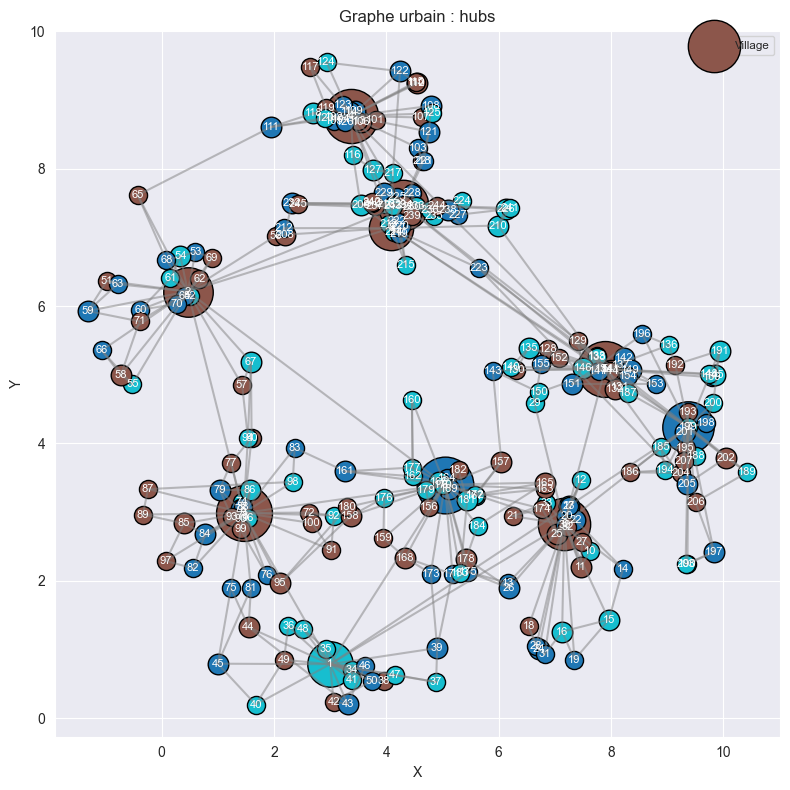

In [17]:
## Clustering V1 (approche par dijkstra et 1 tour de kmean) pas convaincu
import random

'''
Le but ici est à partir d'un sommet de départ(sommet random), calculer la distance entre le sommet et tout les autres sommets
Si la distance au sommet trouvé est inférieur à la distance stockée, alors le sommet prend la nouvelle distance et prend le cluster du sommet en paramètre
De cette manières, tous les sommets se lient au centroide le plus proche
'''
def dijkstraClustering(graphe, depart, cluster):
    visite = set()
    graphe[depart]['distance'] = 0
    graphe[depart]['cluster'] = cluster
    file = [(0, depart)]

    while file:
        file.sort()
        dist_actuelle, noeud_actuel = file.pop(0) 

        if noeud_actuel in visite:
            continue
        visite.add(noeud_actuel)

        for voisin, poids_liste in graphe[noeud_actuel]['neighbours'].items():
            poids = poids_liste[0]
            nouvelle_distance = dist_actuelle + poids
            if nouvelle_distance < graphe[voisin]['distance']:
                graphe[voisin]['distance'] = nouvelle_distance
                graphe[voisin]['cluster'] = cluster
                file.append((nouvelle_distance, voisin))  

'''
On choisi k sommets aléatoires en s'assurant qu'ils soient distincts
Pour chaque sommet, on lance la fonction dijkstraClustering
'''
def launchClustering(k, graphe):
    random_numbers = random.sample(range(len(graphe)), k)
    print('sommets choisi : ' + str(random_numbers))
    index = 0
    for i in random_numbers:
        dijkstraClustering(graphe, i, index)
        index += 1
    return graphe

'''
fonction de debug pour voir les clusters des sommets
'''
def showCluster(graphe):
    for i in graphe:
        print(str(i) + ' -> ' + str(graphe[i]['cluster']))

'''
On utilise cette fonction pour calculer la somme des poids des arêtes pour chaque clusters afin de voir si il y a un équilibre entre les clusters
'''
def calcGraphWeight(graphe, k):
    weightCluster = [0] * k
    somme = 0
    for i in graphe:
        somme += graphe[i]['distance'] 
        weightCluster[graphe[i]['cluster']] += graphe[i]['distance']
    return somme, weightCluster

'''
On calcul la somme des écarts des distances moyenne par rappot au poids total / k afin de sortir un score se rapprochant de 100 si équilibré
'''
def calcQualityClusters(weightSum, weightClusters):
    lenWeightClusters = len(weightClusters)
    #print('optimal ' + str(weightSum/lenWeightClusters))
    diffCalc = 0
    for i in weightClusters:
        diffCalc += abs(weightSum/lenWeightClusters - i)
    #print('diffMoy ' + str(diffCalc/lenWeightClusters))
    return (100 - (diffCalc/lenWeightClusters) / (weightSum/lenWeightClusters) * 100)

'''
Pour un nombre k de cluster donné,
On prend k sommets aléatoire
On lance le clustering
On calcul la qualité de clustering, si ce n'est pas assez de bonne qualité,
on ré-essaye avec de nouveaux sommets aléatoire, si on satisfait la qualité demandé, on termine 
'''
def main(precisionAsk, graphe):
    isOk = False
    while isOk != True:
        grapheTemp = graphe
        k = 3
        grapheTemp = launchClustering(k, grapheTemp)
        weightSum, weightClusters = calcGraphWeight(grapheTemp, k)
        quality = calcQualityClusters(weightSum, weightClusters)
        if(quality > precisionAsk):
            print('quality ' + str(quality))
            isOk = True
    return grapheTemp
graphe2 = main(95, graphe)
plot_graph_data(graphe2, title = 'Graphe urbain : hubs')

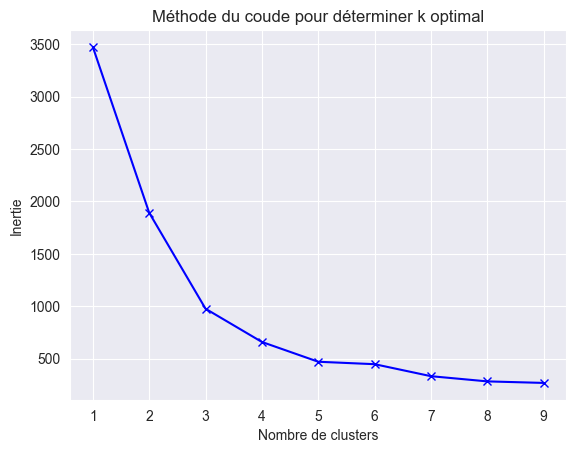

Nombre optimal de clusters : 3


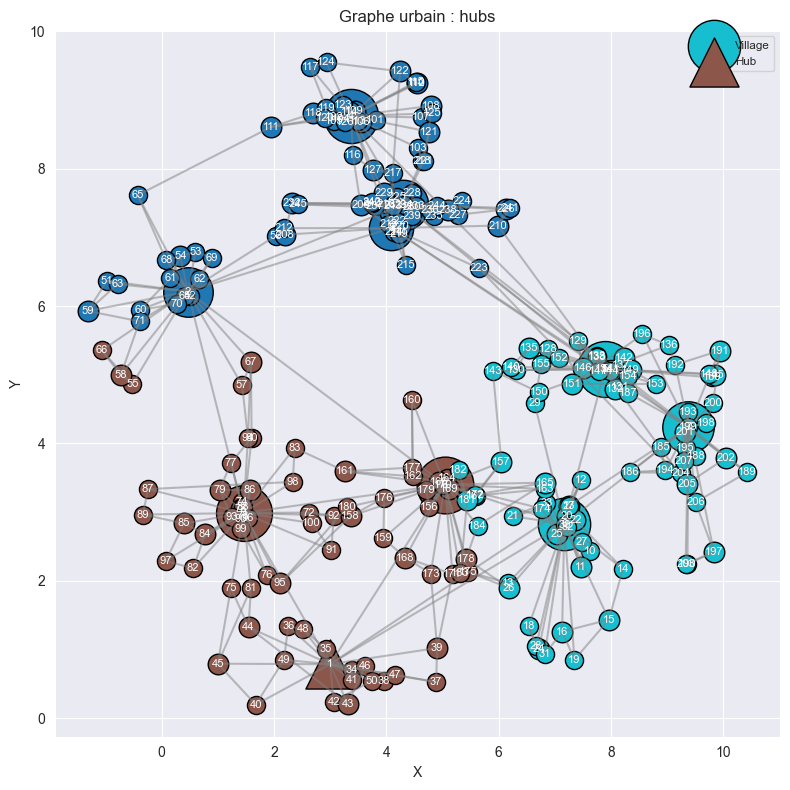

In [18]:
# Clustering v2 avec KMeans

from kneed import KneeLocator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets


'''
On utilise l'inertie ici (distance entre les sommets du cluster et le centroide du cluster) pour voir la qualité des clusters
On test entre 1 et 10 clusters pour voir lequel nombre est le plus adapté
On utilise la méthode elbow pour voir le meilleur nombre de cluster (On cherche la fracture dans le graphe)
'''
def calcBestNbCluster(df):
    inertias = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df)
        inertias.append(kmeans.inertia_)
    
    plt.figure()
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.title('Méthode du coude pour déterminer k optimal')
    plt.show()
    
    kneedle = KneeLocator(K, inertias, curve='convex', direction='decreasing')
    optiK = kneedle.knee
    print("Nombre optimal de clusters : " + str(optiK))
    return optiK

'''
On formate les données pour la lib KMeans
On calcule le nombre optimal de clusters 
On lance KMeans afin d'affecter aux sommets le cluster le plus proche
On en resort les coordonnées des différents centroides, le graphe clusterisé et le nombre de cluster
'''
def clusteringKMeans(graphe):
    xList = []
    yList = []
    for node, data in graphe.items():
        xList.append(data['x'])
        yList.append(data['y'])
    df = np.column_stack((xList, yList))

    optiK = calcBestNbCluster(df)
    
    kmeans = KMeans(n_clusters=optiK, random_state=1)
    kmeans.fit(df)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    for node, data in graphe.items():
        data['cluster'] = labels[node]

    return centroids, graphe, optiK

centroids, graphe, k = clusteringKMeans(graphe)
plot_graph_data(graphe, title = 'Graphe urbain : hubs')

[set(), {58, 66, 55}, {181, 182}]
[set(), set(), set()]


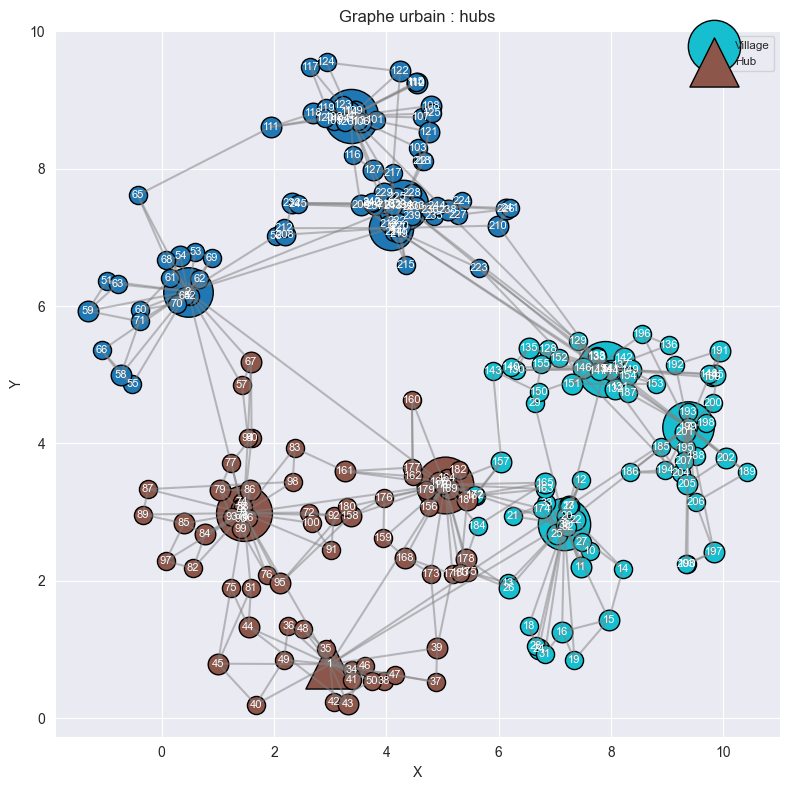

In [19]:
'''
Les centroides passés en paramètres sont des coordonnées
Le but ici est de récupérer pour chaque centroides le point le proche de chaque cluster avec la distance euclidienne
'''
def calcSommet(graphe, centroids):
    centreList = [float('inf')] * len(centroids)
    numberCentreList = [None] * len(centroids) 
    
    for node, data in graphe.items():
        for idx, centre in enumerate(centroids):
            dist = math.sqrt((centre[0] - data['x'])**2 + (centre[1] - data['y'])**2)
            if dist < centreList[idx]:
                centreList[idx] = dist
                numberCentreList[idx] = node
                
    return numberCentreList

'''
Pour un graphe donné, fait plusieurs listes des sommets de chaque cluster 
'''
def divideGInSg(graphe, k):
    listClusters = [[] for i in range(k)]
    for node, data in graphe.items():
        cluster_index = data['cluster']
        listClusters[cluster_index].append(node)
    return listClusters
listGraphe = divideGInSg(graphe, k)

'''
Un dijkstra pour tenter d'acceder à tous les sommets du cluster associé au sommet de départ passé en paramètre
Renvoie la liste des sommets accedés (les sommets connexe au cluster)
'''
def allConnexeSom(graphe, depart):    
    visite = []
    file = [depart]
    while file:
        file.sort()
        noeud_actuel = file.pop(0)
        if noeud_actuel in visite:
            continue
        visite.append(noeud_actuel)
        for voisin in graphe[noeud_actuel]['neighbours']:
            if voisin not in visite and graphe[voisin]['cluster'] == graphe[depart]['cluster']:
                file.append(voisin)
    return visite


'''
Tant qu'il reste des sommets non traités
    On prend un sommet en tant qu'actuel à l'index donné
    On récupère les voisins du sommet actuel qui n'appartiennent pas au meême cluster
        On récupère la distance et le cluster du voisin qu'on stocke dans le tuple à l'index du cluster
    Après avoir traité tous les voisins on récupère les candidats (clusters ayant le plus de voisins)
    Et si il y a égalité, on prend le cluster ayant la distance la plus petite
    On retire le sommet de la liste et on recommence le parcours
    Sinon aucun candidat(Tous les voisins sont du même cluster que le sommet (ça arrive si on a plein de sommets connexe entre eux mais pas connexe à leur cluster))
        On passe à l'index (Sommet) suivant
'''
def associateToNewCluster(graphe, listSomIncoCluster):
    listIncoC = [s for cluster_set in listSomIncoCluster for s in cluster_set]
    index = 0
    while len(listIncoC) > 0 and index < len(listIncoC):
        sommet = listIncoC[index]

        clusterStats = [(0, 0.0) for i in range(len(listSomIncoCluster))]

        for voisin in graphe[sommet]['neighbours']:
            if graphe[sommet]['cluster'] != graphe[voisin]['cluster']:
                distance = graphe[sommet]['neighbours'][voisin]
                voisin_cluster = graphe[voisin]['cluster']
                nb_voisins, total_dist = clusterStats[voisin_cluster]
                clusterStats[voisin_cluster] = (nb_voisins + 1, total_dist + min(distance))

        max_voisins = max(stats[0] for stats in clusterStats)
        candidats = [idx for idx, stats in enumerate(clusterStats) if stats[0] == max_voisins]

        if len(candidats) != 0:
            if len(candidats) == 1:
                bestCluster = candidats[0]
            elif len(candidats) > 1:
                bestCluster = min(candidats, key=lambda idx: clusterStats[idx][1])
            graphe[sommet]['cluster'] = bestCluster
            listIncoC.pop(index)
            index = 0
        else:
            index += 1
    return graphe



'''
Tant que les sous graphes(clusters) ne sont pas connexe sur eux mêmes, on boucle
On récupère les listes de sommets pour chaque clusters
Pour chaque cluster à partir de son centre, 
    on récupère la liste des sommets connexe du cluster
    On regarde la différence entre les sommets du cluster et les sommets accessible 
    Si il y a une différence sur au moins un cluster alors il faut réatribuer les sommets non connexex à un autre cluster (associateToNewCluster)
'''
def forIsConnexe(graphe, centroides, k):
    isAllClusterConnexe = False
    while isAllClusterConnexe == False:
        listSomIncoCluster = [None]*k
        listClusters = divideGInSg(graphe, k)
        isAllClusterConnexe = True
        for idx, centroide in enumerate(centroides):
            listSommet = listClusters[idx]
            connexeSom = allConnexeSom(graphe, centroide)
            difference = set(listSommet) - set(connexeSom)
            if len(difference) != 0:
                isAllClusterConnexe = False
            listSomIncoCluster[idx] = difference
        print(listSomIncoCluster)
        if isAllClusterConnexe == False:
            graphe = associateToNewCluster(graphe, listSomIncoCluster)
    return graphe
        

graphe3 = forIsConnexe(graphe, calcSommet(graphe, centroids), k)

plot_graph_data(graphe3, title = 'Graphe urbain : hubs')

# Diviser le graphe en liste de sous graphes

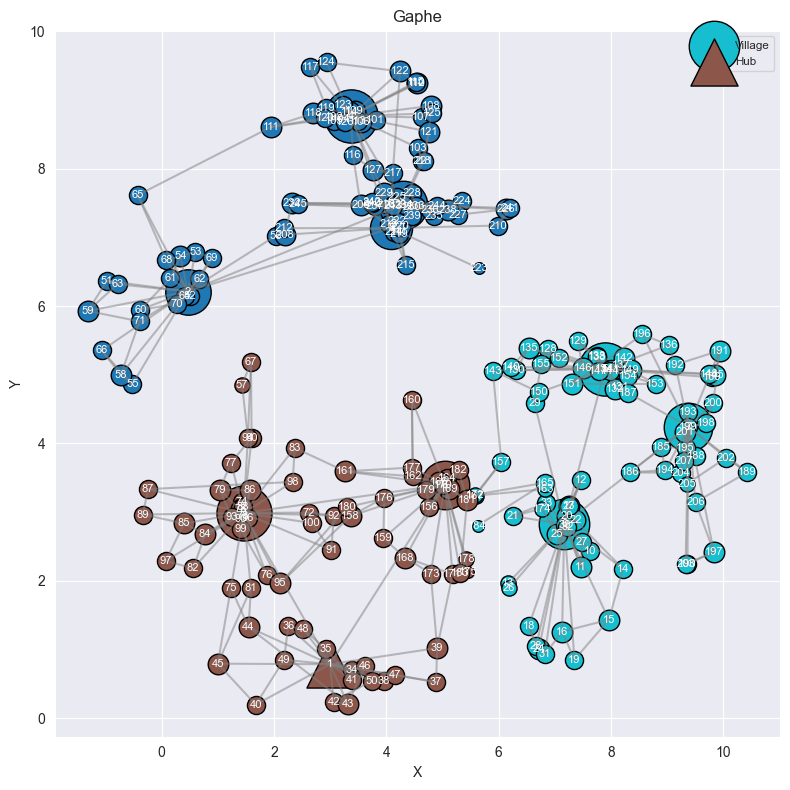

In [38]:
def divideGInSgDict(graphe, k):
    listClusters = [{} for i in range(k)]
    for node, data in graphe.items():
        cluster_index = data['cluster']
        # Remove neighbours that are not in the cluster
        data_copy = copy.deepcopy(data)
        for neighbour in data['neighbours'].keys():
            if graphe[neighbour]['cluster'] != cluster_index:
                del data_copy['neighbours'][neighbour]
        (listClusters[cluster_index])[node] = data_copy
        graphe[node] = data_copy
    return listClusters, graphe
grapheDivise, graphe0 = divideGInSgDict(graphe3, k)
plot_graph_data(graphe0)

# Rendre le graphe complet avec A*

In [21]:
import copy

def heuristic(graph, a, b):
    weights = [w[0] for w in graph[a]['neighbours'].values()]
    return min(weights) if weights else 0

def a_star_weighted(graph, start, goal):
    open_set = [(0, start)]  # liste de tuples (f_score, sommet)
    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0

    while open_set:
        # Trie pour récupérer le noeud avec le plus petit f_score
        open_set.sort(key=lambda x: x[0])
        _, current = open_set.pop(0)

        if current == goal:
            path = []
            total_cost = g_score[goal]
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path, total_cost

        for neighbour, weights in graph[current]['neighbours'].items():
            weight = weights[0]
            tentative_g_score = g_score[current] + weight

            if tentative_g_score < g_score[neighbour]:
                came_from[neighbour] = current
                g_score[neighbour] = tentative_g_score
                f_score = tentative_g_score + heuristic(graph, neighbour, goal)

                # Mise à jour dans open_set : on évite les doublons
                found = False
                for i in range(len(open_set)):
                    if open_set[i][1] == neighbour:
                        if f_score < open_set[i][0]:
                            open_set[i] = (f_score, neighbour)
                        found = True
                        break
                if not found:
                    open_set.append((f_score, neighbour))
    return None, float('inf')


def build_complete_graph(graph):
    graph2 = copy.deepcopy(graph)
    correspondance = {}
    for u in graph:
        for v in graph:
            if u == v or v in graph[u]['neighbours']:
                continue

            path, cost = a_star_weighted(graph, u, v)

            if path and cost < float('inf'):
                correspondance[u,v] = path
                graph2[u]['neighbours'][v] = [cost]
                graph2[v]['neighbours'][u] = [cost]

    return correspondance, graph2

def expand_path_with_mapping(path, edge_mapping):
    """Étend les arêtes du chemin selon le dictionnaire edge_mapping."""
    expanded_path = []
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if (u, v) in edge_mapping:
            segment = edge_mapping[(u, v)]
        elif (v, u) in edge_mapping:
            segment = edge_mapping[(v, u)][::-1]  # inverser si chemin dans l'autre sens
        else:
            segment = [u, v]

        if expanded_path:
            # Évite les doublons entre segments consécutifs
            expanded_path.extend(segment[1:])
        else:
            expanded_path.extend(segment)

    return expanded_path

# Max Min Ant System

In [22]:
import random

N_ANTS = 100
ALPHA = 1.0 # Influence de la trace de phéromone (+ -> fourmis suivent plus la trace)
BETA = 5.0 # Influence de la visibilité (+ -> chemin le plus court)
EVAPORATION_RATE = 0.5 # rho
TAU_MIN = 0.01 # Phéromone minimale
TAU_MAX = 2.0 # Phéromone maximale
STAGNATION_MAX = 500 # Nombre d’itérations sans amélioration avant stagnation

def distance(graph, a, b):
    if b in graph[a]['neighbours']:
        return graph[a]['neighbours'][b][0]  # On utilise le poids comme distance
    return float('inf')


def initialize_pheromones(graph):
    pheromones = {}
    for vertex in graph:
        for neighbour in graph[vertex]['neighbours']:
                pheromones[(vertex, neighbour)] = TAU_MIN
                pheromones[(neighbour, vertex)] = TAU_MIN
    return pheromones


def transition_probability(current, neighbours, pheromones):
    numerators = {}
    total = 0.0

    for neighbour in neighbours:
        weight = min(neighbours[neighbour])
        tau = pheromones.get((current, neighbour, weight), TAU_MIN)
        eta = 1.0 / weight  # heuristic information
        numerators[neighbour] = (tau ** ALPHA) * (eta ** BETA)
        total += numerators[neighbour]

    if total == 0:
        # If all probabilities are 0, distribute equally
        return {n: 1.0 / len(neighbours) for n in neighbours}

    return {n: numerators[n] / total for n in numerators}


def next_vertex(probas):
    r = random.random()
    cumulative = 0.0
    for vertex, prob in probas.items():
        cumulative += prob
        if r <= cumulative:
            return vertex
    return list(probas.keys())[-1]  # fallback


def path_cost(path, graph):
    cost = 0
    for i in range(len(path)-1):
        u = path[i]
        v = path[i+1]
        cost += min(graph[u]['neighbours'][v])
    return cost


def max_min_ant_system(graph, starting_vertex):
    pheromones = initialize_pheromones(graph)
    best_path = None
    best_cost = float('inf')
    stagnation = 0

    # Paramètre dynamique
    N_ANTS = len(graph)//2
    #EVAPORATION_RATE =
    #TAU_MAX = 1 / (EVAPORATION_RATE * )

    while True:
        solutions = []

        # Each ant builds a solution
        for _ in range(N_ANTS):
            path = [starting_vertex]
            current = starting_vertex
            visited = set(path)

            # Build path until all vertices are visited
            while len(visited) < len(graph):
                # Get unvisited neighbors
                neighbors = {
                    n: graph[current]['neighbours'][n]
                    for n in graph[current]['neighbours']
                    if n not in visited
                }

                if not neighbors:
                    break

                # Choose next vertex
                probabilities = transition_probability(current, neighbors, pheromones)
                next_node = next_vertex(probabilities)
                path.append(next_node)
                visited.add(next_node)
                current = next_node

                if len(path) == len(graph):  # Chemin valide (visite tous les sommets)
                    cost = path_cost(path, graph)
                    solutions.append((path, cost))

        # If no solution found, continue
        if not solutions:
            continue

        iteration_best_path, iteration_best_cost = min(solutions, key=lambda x: x[1])

        if iteration_best_cost < best_cost:
            best_path = iteration_best_path
            best_cost = iteration_best_cost
            print("New solution found : ", best_path, "cost : ", best_cost)
            stagnation = 0
        else:
            stagnation += 1

        if stagnation >= STAGNATION_MAX:
            break

        # Évaporation
        for edge in pheromones:
            pheromones[edge] = max(pheromones[edge] * (1 - EVAPORATION_RATE), TAU_MIN)

        # Renforcement du chemin optimal
        delta_tau = 1.0 / best_cost
        for i in range(len(best_path) - 1):
            u = best_path[i]
            v = best_path[i + 1]
            for edge in [(u, v), (v, u)]:
                pheromones[edge] = min(pheromones.get(edge, TAU_MIN) + delta_tau, TAU_MAX)

    if best_path:
        best_path.append(best_path[0])  # cycle hamiltonien

    return best_path, best_cost

# Test Max Min Ant System

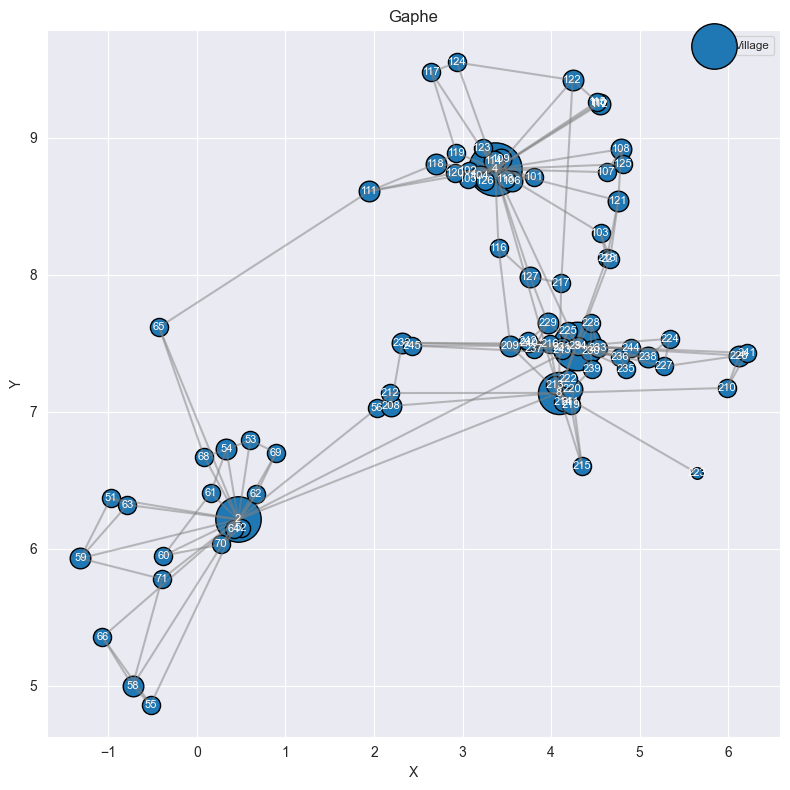

KeyError: 0

In [37]:
for subgraph in grapheDivise:
    plot_graph_data(subgraph)
    correspondance, newGraph = build_complete_graph(subgraph)
    best_path, best_cost = max_min_ant_system(newGraph, 0)
    expanded_path = expand_path_with_mapping(best_path, correspondance)
    print("Meilleur chemin :", expanded_path)
    print("Coût total :", best_cost)